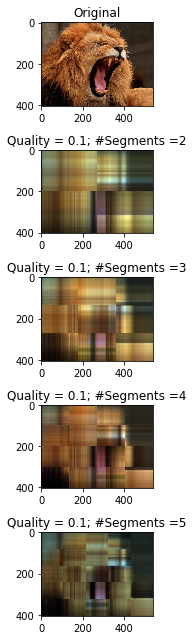

In [20]:
# %load hint.py
#!/usr/bin/env python3

# Low Rank Approximation by Image Segmentation
# Written by Prof. R.S. Sreenivas
# For IE531: Algorithms for Data Analytics
# 
import sys
import argparse
import numpy as np 
import time
import math
import matplotlib.pyplot as plt
import cv2
import os
np.set_printoptions(precision=5)

# computing the desired low-rank approximation by adding sufficient number of singular values
def compute_lower_rank_approx_via_SVD(data_matrix, desired_quality) :
    # Write this part
    # Keep in mind that the rank of the block-matrices might be less than the number of rows
    # in the matrix... See the blurb on "Full Matrices" at the svd documentation here
    # https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.svd.html
    #print(data_matrix)
    #if desired_quality == 1:
        #return data_matrix
    U, sigma, V = np.linalg.svd(data_matrix) #svd
    s = 0 #sum
    for i in range(len(sigma)):
        s += sigma[i]
        if s/sum(sigma) >= desired_quality: #stop when sum/sum(sigma) >= quality
            break #stop and record i        
    #print(desired_quality, sigma, i, sigma[:i])
    current_approximant = np.matrix(U[:, :i+1]) * np.diag(sigma[:i+1]) * np.matrix(V[:i+1, :]) #select up to i sigma
    #print(data_matrix)
    #print(current_approximant)
    #print(current_approximant)
    return current_approximant

# this function divides the n x d data matrix into k-many "even-ly divided, as closely as possible" 
# blocks.  For example, a (9 x 9) matrix split 4 ways (i.e. k=4) would result in a matrix with shape
# [[(3,3),(2,2),(2,2),(2,2)], [(2,2),(2,2),(2,2),(2,2)], [(2,2),(2,2),(2,2),(2,2)], [(2,2),(2,2),(2,2),(2,2)]]; 
# a (10 x 10) matrix split 4 ways (i.e. k = 4) would result in a matrix with shape
# [[(3,3),(3,3),(3,2),(3,2)], [(3,3),(3,3),(3,2),(3,2)], [(2,3),(2,3),(2,2),(2,2)], [(2,3),(2,3),(2,2),(2,2)]];
# a (11 x 11) matrix split 4 ways (i.e. k = 4) would result in a matrix with shape
# [[(3,3),(3,3),(3,3),(2,2)], [(3,3),(3,3),(3,3),(2,2)], [(2,3),(2,3),(2,3),(2,2)], [(2,3),(2,3),(2,3),(2,2)]];
# etc etc etc
#
def compute_image_block(data_matrix, k) :
    # Fill code here
    # image_block is a (k x k) matrix, where the (i,j)-th entry is a matrix of appropriate shape
    n, d = data_matrix.shape
    mode_height = n//k
    extra_height = n%k 
    #print(mode_height, extra_height)
    heights = [mode_height for i in range(k)]
    for i in range(extra_height):
        heights[i%k] += 1
    mode_width = d//k
    extra_width = d%k
    widths = [mode_width for i in range(k)]
    for i in range(extra_width):
        widths[i%k] += 1
    #print(heights, widths)
    
    image_block = []
    curr_row, curr_col = 0, 0
    for row in range(len(heights)):
        blocks = []
        curr_col = 0
        for col in range(len(widths)):
            height = heights[row]
            width = widths[col]
            blocks.append(data_matrix[curr_row:curr_row+height,curr_col:curr_col+width]) #assume datamatrix is np.matrix
            curr_col += width
        curr_row += height
        image_block.append(blocks)
    #print(np.array(image_block))
    return image_block


# find the lower rank approximation for a given quality on each block of segmented data
# the "verbose" boolean variable is set to True if we want to print the shape of the segmented data
def get_approximation(data_matrix, k, quality, verbose) :
    # Fill code here
    # First -- take the data_matrix and cut it up into (k x k) blocks, where each (i,j)-entry is a
    # matrix of appropriate size
    image_block = compute_image_block(data_matrix, k)
    blocked_data_matrix = []
    # Second -- find the approximants for each matrix that is the (i,j)-th entry of the block
    for i, blocks in enumerate(image_block):
        b = []
        for j, block in enumerate(blocks):
            if verbose:
                x, y = np.array(block).shape
                print('Shape of ( %d , %d ) block: ( %d, %d )' %(i+1, j+1, x, y))
            b.append(compute_lower_rank_approx_via_SVD(block, quality))
        blocked_data_matrix.append(b)
    # Third -- reconstruct the approximant to the data-matrix from the block-approximants
    # The "verbose" boolean is for the printing the shapes of the segmented blocks
    return reconstruct_data_from_image_block(blocked_data_matrix, k)

# this function takes the k x k image_block and reconstucts a single data_matrix from it
def reconstruct_data_from_image_block(image_block, k) :
    # Fill code here
    # image_block is a (k x k) matrix (of matrices) -- where the (i,j)-entry is a matrix of
    # appropriate size
    # you have to "combine" these matrices in the (i,j)-entries and get a single matrix
    for i, blocks in enumerate(image_block):
        if i == 0:
            for idx, block in enumerate(blocks):
                if idx == 0:
                    block_row = block
                else:
                    block_row = np.concatenate((block_row, block), axis=1) #concat horizontally
            data_matrix = block_row
        else:
            for idx, block in enumerate(blocks):
                if idx == 0:
                    block_row = block
                else:
                    block_row = np.concatenate((block_row, block), axis=1) #concat horizontally
            data_matrix = np.concatenate((data_matrix, block_row), axis=0) #concat vertically
    return data_matrix

# verifying the block reconstruction procedure
#A = np.random.random((10,10))
#B = get_approximation(A, 4, 1, True)
#C = get_approximation(A, 4, 0.9, False)
#print(A)
#print(C)
#print(np.allclose(A,B))
#print(np.allclose(A,C))

# matrix computations will yield a 64-bit floating point number; for images we need these
# to converted into the range 0 to 255 of 8-bit ints 
def convert_float64_to_uint8(A) :
    A = A/A.max()
    A = 255 * A
    return A.astype(np.uint8)

# this function "combines" the three color matrices (in the required order) to form a 3D
# array that can be rendered/viewed 
def reconstruct_image_from_RGB_64bit_matrices(red, blue, green) :
    reconstructed_image = cv2.merge([convert_float64_to_uint8(blue), 
                                     convert_float64_to_uint8(green), 
                                     convert_float64_to_uint8(red)])
    return reconstructed_image

# first command-line variable is the image path
#IMAGE = str(sys.argv[1])
#IMAGE = 'banner.png'
IMAGE = 'lion.jpg'
image = cv2.imread(IMAGE)

# we need to change the colorspace to make the colors in the image look right
# when we do an imshow 
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# if you want to work with a grayscale image comment the previous line & 
# uncomment the line below
#gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# split the image into blue-green-red components -- keep in mind that each of 
# these entries are 8-bit ints (i.e. have a value between 0 and 255)
blue_image = image[:,:,0]
green_image = image[:,:,1]
red_image = image[:,:,2]

# second command-line variable is the quality/fidelity of approximation
#quality = float(sys.argv[2])
quality = 0.1

# let us try k = 2, 3, 4, 5 and see how the image segmentation works out

# from https://matplotlib.org/gallery/subplots_axes_and_figures/figure_title.html and 
# from https://stackoverflow.com/questions/41530975/set-size-of-subplot-in-matplotlib
fig = plt.figure(figsize=(6, 9))
image_index = 1
axs = fig.add_subplot(5,1, image_index)
fig.tight_layout()
plt.imshow(image)
axs.set_title('Original')
image_index = image_index + 1

for k in range(2,6) :
    b = get_approximation(blue_image, k, quality, False)
    g = get_approximation(green_image, k, quality, False)
    r = get_approximation(red_image, k, quality, False)
    axs = fig.add_subplot(5,1, image_index)
    fig.tight_layout()
    reconstructed_image = reconstruct_image_from_RGB_64bit_matrices(r, b, g)
    plt.imshow(reconstructed_image)
    axs.set_title('Quality = ' + str(round(quality,5)) + '; #Segments =' + str(k))
    image_index = image_index + 1
    
plt.savefig("fig1.pdf", bbox_inches='tight')
plt.show()

